In [1]:
%matplotlib inline

# Conditional clade probability summaries

## Edit primates data to five taxa
Five taxa is the smallest where we actually have to make the conditional independence assumption; we might observe a clade of greater than size 2 as the child of different parents.

In [2]:
from Bio.Nexus.Nexus import Nexus

nexus = Nexus()
nexus.read('../data/Influenza.nexus')
nexus

In [3]:
nexus.taxlabels

['CY068129_A_California_VRDL396_2009_2009/04/28',
 'CY068870_A_California_VRDL392_2009_2009/04/28',
 'CY068686_A_California_VRDL181_2009_2009/04/28',
 'CY068137_A_California_VRDL159_2009_2009/04/28',
 'CY068217_A_California_VRDL173_2009_2009/04/28',
 'CY068702_A_California_VRDL184_2009_2009/04/28',
 'CY068742_A_California_VRDL199_2009_2009/04/28',
 'CY068766_A_California_VRDL204_2009_2009/04/28',
 'CY068718_A_California_VRDL187_2009_2009/04/28',
 'CY068209_A_California_VRDL172_2009_2009/04/28',
 'CY064879_A_California_VRDL147_2009_2009/04/28',
 'CY068678_A_California_VRDL178_2009_2009/04/28',
 'CY068233_A_California_VRDL211_2009_2009/04/28',
 'CY068734_A_California_VRDL198_2009_2009/04/28',
 'CY068633_A_California_VRDL394_2009_2009/04/28',
 'CY068153_A_California_VRDL161_2009_2009/04/28',
 'CY068161_A_California_VRDL164_2009_2009/04/28',
 'CY067221_A_California_VRDL302_2009_2009/04/28',
 'CY068758_A_California_VRDL203_2009_2009/04/28',
 'CY092329_A_California_VRDL182_2009_2009/04/28',


In [4]:
# TODO: Return all with 5 taxa
nexus.write_nexus_data('../data/Influenza-short.nex', delete=nexus.taxlabels[5:])

'../data/Influenza-short.nex'

## Data structures for conditional clades

In [5]:
from splits import Split

## Processing MCMC output

In [8]:
from Bio import Phylo
trees = list(Phylo.parse('../data/Influenza-short.trees', format='nexus'))
len(trees)

10001

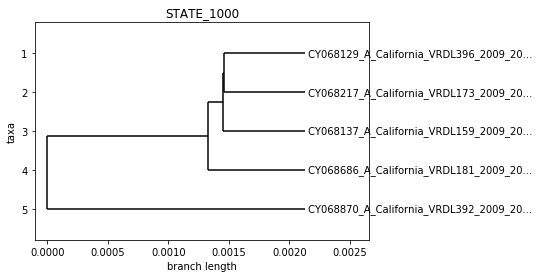

In [9]:
tree = trees[1]
Phylo.draw(tree)

In [10]:
def get_taxa(clade):
    return frozenset([leaf.name for leaf in clade.get_terminals()])
clade = list(tree.find_clades())[2]
clade.branch_length, get_taxa(clade)

(0.00012464565757352433,
 frozenset({'CY068129_A_California_VRDL396_2009_2009/04/28',
            'CY068137_A_California_VRDL159_2009_2009/04/28',
            'CY068217_A_California_VRDL173_2009_2009/04/28'}))

In [11]:
all_taxa = list(get_taxa(tree.root))
name_mapping = { name: str(i) for i, name in enumerate(all_taxa)}
name_mapping

{'CY068129_A_California_VRDL396_2009_2009/04/28': '4',
 'CY068137_A_California_VRDL159_2009_2009/04/28': '1',
 'CY068217_A_California_VRDL173_2009_2009/04/28': '3',
 'CY068686_A_California_VRDL181_2009_2009/04/28': '0',
 'CY068870_A_California_VRDL392_2009_2009/04/28': '2'}

In [12]:
for tree in trees:
    for clade in tree.find_clades():
        if clade.name is not None:
            clade.name = name_mapping[clade.name]

list(tree.find_clades())

[Clade(branch_length=0.0),
 Clade(branch_length=0.0001592378942861599),
 Clade(branch_length=1.377413413478014e-05),
 Clade(branch_length=0.00018363989578841652),
 Clade(branch_length=0.0016325343789806669, name='4'),
 Clade(branch_length=0.0016325343789806669, name='2'),
 Clade(branch_length=0.0018161742747690834, name='3'),
 Clade(branch_length=0.0018299484089038635, name='1'),
 Clade(branch_length=0.0019891863031900234, name='0')]

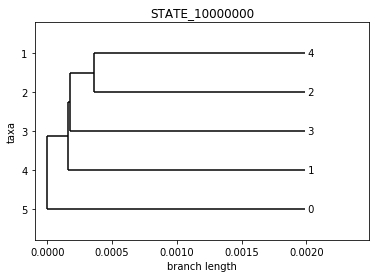

In [13]:
Phylo.draw(tree)

### Marginal posterior

In [14]:
bio_tree = tree

In [15]:
len(bio_tree.root)

2

In [16]:
bio_tree.get_path(bio_tree.get_terminals()[0])

[Clade(branch_length=0.0001592378942861599),
 Clade(branch_length=1.377413413478014e-05),
 Clade(branch_length=0.00018363989578841652),
 Clade(branch_length=0.0016325343789806669, name='4')]

In [45]:
from importlib import reload
import splits
reload(splits)

<module 'splits' from '/mnt/c/chris/git/phylo-hacking/cc/splits.py'>

In [18]:
from splits import TreeNode

def convert_tree(clade):
    if(len(clade)) == 0:
        return clade.name
    else:
        return TreeNode(*[convert_tree(child) for child in clade])

convert_tree(bio_tree.root)

TreeNode(0,(1,((2,4),3)))

In [19]:
from tqdm import tqdm_notebook as tqdm

tree_counts = {}

for bio_tree in tqdm(trees):
    clade = bio_tree.root
    tree = convert_tree(clade)
    if tree in tree_counts:
        tree_counts[tree] += 1
    else:
        tree_counts[tree] = 1

tree_counts

HBox(children=(IntProgress(value=0, max=10001), HTML(value='')))

{TreeNode((((0,1),2),3),4): 104,
 TreeNode((((0,1),2),4),3): 49,
 TreeNode((((0,1),3),2),4): 233,
 TreeNode((((0,1),3),4),2): 221,
 TreeNode((((0,1),4),2),3): 41,
 TreeNode((((0,1),4),3),2): 125,
 TreeNode((((0,2),1),3),4): 52,
 TreeNode((((0,2),1),4),3): 27,
 TreeNode((((0,2),3),1),4): 51,
 TreeNode((((0,2),3),4),1): 15,
 TreeNode((((0,2),4),1),3): 25,
 TreeNode((((0,2),4),3),1): 11,
 TreeNode((((0,3),1),2),4): 200,
 TreeNode((((0,3),1),4),2): 215,
 TreeNode((((0,3),2),1),4): 117,
 TreeNode((((0,3),2),4),1): 48,
 TreeNode((((0,3),4),1),2): 111,
 TreeNode((((0,3),4),2),1): 29,
 TreeNode((((0,4),1),2),3): 20,
 TreeNode((((0,4),1),3),2): 66,
 TreeNode((((0,4),2),1),3): 19,
 TreeNode((((0,4),2),3),1): 17,
 TreeNode((((0,4),3),1),2): 70,
 TreeNode((((0,4),3),2),1): 30,
 TreeNode(((0,(1,2)),3),4): 71,
 TreeNode(((0,(1,2)),4),3): 29,
 TreeNode(((0,(1,3)),2),4): 474,
 TreeNode(((0,(1,3)),4),2): 455,
 TreeNode(((0,(1,4)),2),3): 36,
 TreeNode(((0,(1,4)),3),2): 83,
 TreeNode(((0,(2,3)),1),4): 76

In [20]:
def normalise_dict_entries(dict_):
    sum_ = sum(dict_.values())
    return { key: value/sum_ for key, value in dict_.items() }

p = normalise_dict_entries(tree_counts)
p

{TreeNode((((0,1),2),3),4): 0.0103989601039896,
 TreeNode((((0,1),2),4),3): 0.004899510048995101,
 TreeNode((((0,1),3),2),4): 0.023297670232976703,
 TreeNode((((0,1),3),4),2): 0.022097790220977902,
 TreeNode((((0,1),4),2),3): 0.0040995900409959,
 TreeNode((((0,1),4),3),2): 0.0124987501249875,
 TreeNode((((0,2),1),3),4): 0.0051994800519948,
 TreeNode((((0,2),1),4),3): 0.0026997300269973002,
 TreeNode((((0,2),3),1),4): 0.005099490050994901,
 TreeNode((((0,2),3),4),1): 0.0014998500149985001,
 TreeNode((((0,2),4),1),3): 0.0024997500249975004,
 TreeNode((((0,2),4),3),1): 0.0010998900109989002,
 TreeNode((((0,3),1),2),4): 0.019998000199980003,
 TreeNode((((0,3),1),4),2): 0.021497850214978503,
 TreeNode((((0,3),2),1),4): 0.011698830116988301,
 TreeNode((((0,3),2),4),1): 0.0047995200479952005,
 TreeNode((((0,3),4),1),2): 0.0110988901109889,
 TreeNode((((0,3),4),2),1): 0.0028997100289971,
 TreeNode((((0,4),1),2),3): 0.001999800019998,
 TreeNode((((0,4),1),3),2): 0.0065993400659934,
 TreeNode(((

(array([44., 29., 13.,  6.,  7.,  1.,  3.,  0.,  0.,  2.]),
 array([0.00109989, 0.00572943, 0.01035896, 0.0149885 , 0.01961804,
        0.02424758, 0.02887711, 0.03350665, 0.03813619, 0.04276572,
        0.04739526]),
 <a list of 10 Patch objects>)

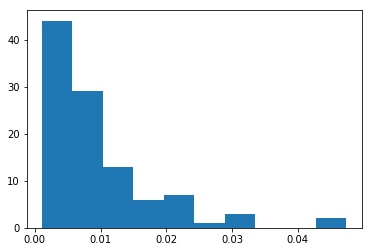

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(p.values())

In [26]:
import pickle

with open('p.pickle', 'wb') as f:
    pickle.dump(p, f)

### Conditional clade summary

In [27]:
from splits import Split

subclade_counts = {}

for tree in tqdm(trees):
    for clade in tree.find_clades():
        taxa = get_taxa(clade)
        if len(taxa) > 2:
            if taxa not in subclade_counts:
                subclade_counts[taxa] = {}
            conditional_split = Split(taxa, get_taxa(clade[0]))
            if conditional_split not in subclade_counts[taxa]:
                subclade_counts[taxa][conditional_split] = 1
            else:
                subclade_counts[taxa][conditional_split] += 1
subclade_counts

HBox(children=(IntProgress(value=0, max=10001), HTML(value='')))

{frozenset({'0', '1', '4'}): {Split({'0', '4', '1'}, {'0', '1'}): 283,
  Split({'0', '4', '1'}, {'0', '4'}): 149,
  Split({'0', '4', '1'}, {'0'}): 202},
 frozenset({'0',
            '1',
            '2',
            '4'}): {Split({'2', '0', '4', '1'}, {'2', '0', '1'}): 105, Split({'2', '0', '1', '4'}, {'0', '1', '4'}): 97, Split({'2', '1', '4', '0'}, {'1', '0'}): 29, Split({'2', '0', '4', '1'}, {'2', '0', '4'}): 57, Split({'2', '0', '4', '1'}, {'2', '0'}): 34, Split({'2', '0', '4', '1'}, {'0', '4'}): 36, Split({'2', '0', '4', '1'}, {'0'}): 69},
 frozenset({'1', '3', '4'}): {Split({'1', '4', '3'}, {'1', '3'}): 655,
  Split({'1', '4', '3'}, {'1', '4'}): 213,
  Split({'1', '4', '3'}, {'1'}): 223},
 frozenset({'0', '1', '3'}): {Split({'1', '0', '3'}, {'1', '0'}): 574,
  Split({'0', '1', '3'}, {'0', '3'}): 527,
  Split({'0', '1', '3'}, {'0'}): 1161},
 frozenset({'0',
            '1',
            '3',
            '4'}): {Split({'0', '4', '1', '3'}, {'0', '1', '3'}): 891, Split({'0', '1', '4'

In [28]:
split_p = { clade: normalise_dict_entries(subclades) for clade, subclades in subclade_counts.items() }
split_p

{frozenset({'0',
            '1',
            '4'}): {Split({'0', '4', '1'}, {'0', '1'}): 0.44637223974763407, Split({'0', '4', '1'}, {'0', '4'}): 0.23501577287066247, Split({'0', '4', '1'}, {'0'}): 0.3186119873817035},
 frozenset({'0',
            '1',
            '2',
            '4'}): {Split({'2', '0', '4', '1'}, {'2', '0', '1'}): 0.2459016393442623, Split({'2', '0', '1', '4'}, {'0', '1', '4'}): 0.22716627634660422, Split({'2', '1', '4', '0'}, {'1', '0'}): 0.06791569086651054, Split({'2', '0', '4', '1'}, {'2', '0', '4'}): 0.13348946135831383, Split({'2', '0', '4', '1'}, {'2', '0'}): 0.07962529274004684, Split({'2', '0', '4', '1'}, {'0', '4'}): 0.08430913348946135, Split({'2', '0', '4', '1'}, {'0'}): 0.16159250585480095},
 frozenset({'1',
            '3',
            '4'}): {Split({'1', '4', '3'}, {'1', '3'}): 0.6003666361136571, Split({'1', '4', '3'}, {'1', '4'}): 0.19523373052245646, Split({'1', '4', '3'}, {'1'}): 0.20439963336388633},
 frozenset({'0',
            '1',
           

In [29]:
from operator import mul
from functools import reduce
from splits import get_clade

prod = lambda xs: reduce(mul, xs)

def get_split_p(clade, split, split_ps):
    if clade in split_ps:
        if split in split_ps[clade]:
            return split_ps[clade][split]
        else:
            return 0.0
    else:
        return 0.0
    
def p_approx(tree, split_ps):
    if isinstance(tree, str):
        return 1.0
    else:
        children = tree.get_children()
        if all([isinstance(child, str) for child in children]):
            return 1.0
        else:
            clade = tree.get_clade()
            subtree_p_approxs = [p_approx(subtree, split_ps) for subtree in children]
            split = Split(tree.get_clade(), get_clade(children[0]))
            split_p = get_split_p(clade, split, split_ps)
            return split_p*prod(subtree_p_approxs)
    
p_approxs = { tree: p_approx(tree, split_p) for tree in p.keys() }
p_approxs

{TreeNode((((0,1),2),3),4): 0.010327281510801457,
 TreeNode((((0,1),2),4),3): 0.00477693638164825,
 TreeNode((((0,1),3),2),4): 0.02301352534949865,
 TreeNode((((0,1),3),4),2): 0.0226075535682506,
 TreeNode((((0,1),4),2),3): 0.004329377787773273,
 TreeNode((((0,1),4),3),2): 0.012229376431442028,
 TreeNode((((0,2),1),3),4): 0.005535125701832436,
 TreeNode((((0,2),1),4),3): 0.0025603004347683075,
 TreeNode((((0,2),3),1),4): 0.00519097026467566,
 TreeNode((((0,2),3),4),1): 0.001850878741913043,
 TreeNode((((0,2),4),1),3): 0.0022186592529558234,
 TreeNode((((0,2),4),3),1): 0.0015958777082664694,
 TreeNode((((0,3),1),2),4): 0.02112914261182193,
 TreeNode((((0,3),1),4),2): 0.020756412422418234,
 TreeNode((((0,3),2),1),4): 0.011679683095520236,
 TreeNode((((0,3),2),4),1): 0.004164477169304347,
 TreeNode((((0,3),4),1),2): 0.010953071359530714,
 TreeNode((((0,3),4),2),1): 0.003584641535846415,
 TreeNode((((0,4),1),2),3): 0.002279425054339992,
 TreeNode((((0,4),1),3),2): 0.006438788297826369,
 Tr

In [30]:
{ tree: (p[tree], p_approxs[tree]) for tree in p.keys() }

{TreeNode((((0,1),2),3),4): (0.0103989601039896, 0.010327281510801457),
 TreeNode((((0,1),2),4),3): (0.004899510048995101, 0.00477693638164825),
 TreeNode((((0,1),3),2),4): (0.023297670232976703, 0.02301352534949865),
 TreeNode((((0,1),3),4),2): (0.022097790220977902, 0.0226075535682506),
 TreeNode((((0,1),4),2),3): (0.0040995900409959, 0.004329377787773273),
 TreeNode((((0,1),4),3),2): (0.0124987501249875, 0.012229376431442028),
 TreeNode((((0,2),1),3),4): (0.0051994800519948, 0.005535125701832436),
 TreeNode((((0,2),1),4),3): (0.0026997300269973002, 0.0025603004347683075),
 TreeNode((((0,2),3),1),4): (0.005099490050994901, 0.00519097026467566),
 TreeNode((((0,2),3),4),1): (0.0014998500149985001, 0.001850878741913043),
 TreeNode((((0,2),4),1),3): (0.0024997500249975004, 0.0022186592529558234),
 TreeNode((((0,2),4),3),1): (0.0010998900109989002, 0.0015958777082664694),
 TreeNode((((0,3),1),2),4): (0.019998000199980003, 0.02112914261182193),
 TreeNode((((0,3),1),4),2): (0.02149785021497

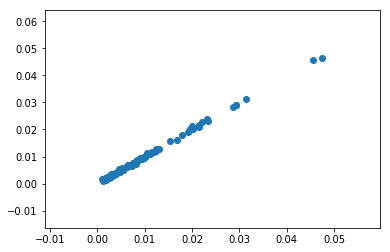

In [32]:
p_list, p_approx_list = zip(*[(p[tree], p_approxs[tree]) for tree in p.keys()])
plt.scatter(p_list, p_approx_list)

In [49]:
from math import log

# Assume p contains all trees
def kl(p, split_ps):
    def tree_term(p, p_approx):
        return p_approx*(log(p_approx) - log(p)) if p_approx > 0 else 0
    return sum([tree_term(p[tree], p_approx(tree, split_ps)) for tree in p])

kl(p, split_p)

0.0012321255861456

In [54]:
split_p_list = [(split, p) for parent, splits in split_p.items() for split, p in splits.items()]
split_p_list = sorted(split_p_list, key = lambda x: x[1], reverse=True)

def rebuild_split_dict(split_list):
    split_dict = {}
    for split, split_p in split_list:
        parent = split.get_parent()
        if parent not in split_dict:
            split_dict[parent] = {}
        split_dict[parent][split] = split_p
    return { parent: normalise_dict_entries(split_ps) for parent, split_ps in split_dict.items() }

kl(p, rebuild_split_dict(split_p_list[:-1]))

0.02328706465825252

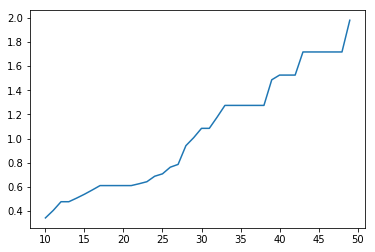

In [57]:
n_splits = list(range(10, 50))
kls = [kl(p, rebuild_split_dict(split_p_list[:-i])) for i in n_splits]
plt.plot(n_splits, kls)